# Goal

In this notebook we implement faster rcnns.  I will start with a region proposal network only.

We first need a dataset.

Note the standard format for bounding boxes is x,y,width height.  i.e. units of pixels, but potentially with decimals.



# YOLO
In yolo (you only look once) we will have B bounding boxes per pixel, and the pixels are large and cover the whole image.

The pixel in which the center of an object lies is responsible for detecting the object.

Each of the bounding boxes output is 5 numbers, (x,y) (the center, not corner) width, height, confidence.

Confidence is a prediction of IOU

Additionally, each cell predicts a probability distribution over class labels.




# Color module
We can use my attention mechanism to give some sort of a color module.

Say I have a variable number of colors N, and I want to map to a fixed number M.

We get M convolution filters.

We filter each image with each filter.  This gives an N x M array of images.

We then apply a softmax to it.  We then do matrix multiplication.



# TODO
use running mean batch norm

fix rotated bounding boxes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.collections import PolyCollection
# %matplotlib notebook
%matplotlib widget
from os import makedirs
from os.path import join

from scipy.ndimage import gaussian_filter

user = 'abenneck'
# user = 'dtward'

In [2]:
dtype = torch.float32

In [3]:
resume = True # if True, will load a saved model
if user == 'abenneck':
    outdir = '/home/abenneck/Desktop/YOLO/yolo_saved_models_v01'
else:
    outdir = 'yolo_saved_models_v01'
modelname = 'modelsave.pt'
optimizername = 'optimizersave.pt'
lossname = 'loss.pt'
makedirs(outdir,exist_ok=True)

In [4]:
nclasses = 3
# I have it implemented for 3 as well below, but the 3rd class is too slow currently

In [5]:
class GroundTruthDataset(torch.utils.data.Dataset):
    ''' This dataset will generate random images.
    
    The images will be square size N
    
    And they will contain poisson distributed cells with mean M.
    
    We will also output a list of bounding boxes, normalized between 0 and 1, of the form X,Y,W,H
    
    '''
    def __init__(self,N=256,M=64,reproducible=False):
        M = 256 # denser
        M = 350
        self.N = N
        self.M = M
        self.reproducible = reproducible
        
        
    def __len__(self):
        #return 1000
        return 100
        #return 1
        
    def __getitem__(self,i):
        if self.reproducible: np.random.seed(i)
        
        # initialize the image
        d = np.random.randint(4)+1
        bg = np.random.rand(d)
        I = np.zeros((d,self.N,self.N)) + bg[...,None,None]
        # how many cells
        m = np.random.poisson(self.M)
        m = 1+np.random.randint(self.M)
        
        # sample conditionally uniform centers
        c = np.random.rand(m,2)
        c = c * (np.array(I.shape[1:])-1)
        
        # sample the sizes, they will all be isotropic here to start
        s = 10*np.exp(np.random.randn(m,2)*0.2)
        s = 5*np.exp(np.random.randn(m,2)*0.2 + 1) # try smaller, but with variance
        s = 3 + np.random.rand(m,2)*20 # 
        # from 5 to 25
        # 
        
        
        #s[:,1] = s[:,0]
        #s[:,1] = (s[:,0] + (s[:,1]-s[:,0])*0.5)#*0+5
        
        
        
        
        # note bbox is xy not row col
        theta = (np.random.rand(m)-0.5)*np.pi/2
        theta = np.random.rand(m)*np.pi*2
        # we will use the original s'ss below
        # but define a new variable for the bounding boxes
        sr = np.stack((
            np.sqrt(  np.cos(theta)**2*s[:,0]**2 + np.sin(theta)**2*s[:,1]**2 ),
            np.sqrt(  np.cos(theta)**2*s[:,1]**2 + np.sin(theta)**2*s[:,0]**2 ),
        ),-1)
        bbox = np.stack((c[:,0]-sr[:,0]/2, c[:,1]-sr[:,1]/2, sr[:,0], sr[:,1]   ), -1)
        
        # convert to pixels
        
        
        # now the image
        rows = np.arange(I.shape[1])
        cols = np.arange(I.shape[2])
        Rows,Cols = np.meshgrid(rows,cols,indexing='ij')
        
        #cl = (np.random.rand(m)>0.5).astype(int) # will be 0 or 1, later they will be 1,2 with 0 reserved for background
        cl = np.random.randint(low=0,high=nclasses,size=m)
        #cl = cl*0+2
        
        # NOTE I think this method of drawing the dataset is too slow
        # I think I need to cut out a bounding box
        color0 = np.random.rand(d)
        for ci,si,cli,ti in zip(c,s,cl,theta):
            # get a window
            mxi = np.max(si)
            left = np.maximum(ci[0]-3*mxi,0).astype(int)
            right = np.minimum(ci[0]+3*mxi,I.shape[-1]-1).astype(int)
            top = np.maximum(ci[1]-3*mxi,0).astype(int)
            bottom = np.minimum(ci[1]+3*mxi,I.shape[-2]-1).astype(int)
            
            # ROTATION                        
            theta = ti
            Rows_ = (Rows-ci[1])*np.cos(theta) - (Cols-ci[0])*np.sin(theta)
            Cols_ = (Rows-ci[1])*np.sin(theta) + (Cols-ci[0])*np.cos(theta)
            
            if cli <= 1:
                mask = np.exp(-(((Rows_[...,top:bottom,left:right]/si[1])**2 + (Cols_[...,top:bottom,left:right]/si[0])**2)/2*3**2)**(1 + 2*cli)) 
            else:
                mask = np.exp(-(((Rows_[...,top:bottom,left:right]/si[1])**2 + (Cols_[...,top:bottom,left:right]/si[0])**2)/2*3**2)**4 )
                bumps = np.random.randn(d,mask.shape[0],mask.shape[1])
                bumps = gaussian_filter(bumps,1)
                mask = np.exp(bumps)*mask
                # the below approach is way too slow
                #mask = np.zeros_like(Rows_[...,top:bottom,left:right])                
                #for i in range(int(1*np.prod(si))):#range(np.random.geometric(0.5)+1):                    
                #    # below unit area normalized
                #    mask = mask +  np.exp(-(((Rows_[...,top:bottom,left:right] -np.random.randn()*si[1]/4)**2 + (Cols_[...,top:bottom,left:right] - np.random.randn()*si[0]/4)**2)/2/2**2) )/(2.0*np.pi*2**2)/2
                
            #color = (0.1+0.9*np.random.rand())
            color = color0*0.95 + np.random.rand(d)*0.05
            #I[...,top:bottom,left:right] = I[...,top:bottom,left:right]*(1-mask) + color*mask
            # just add
            
            I[...,top:bottom,left:right] = I[...,top:bottom,left:right] + color[...,None,None]*mask
        # artifact?
        # I'd like to add a line
        theta = np.random.rand()*2.0*np.pi
        perp = (Rows - np.random.rand()*I.shape[-2])*np.cos(theta) + (Cols - np.random.rand()*I.shape[-1])*np.sin(theta)
        mask = np.exp(-(perp/(1+np.random.rand()*20))**2)
        color = np.random.rand(d)*2
        
        #I = I*(1-mask) +color*mask
        # just add
        I = I + color[...,None,None]*mask
        
        
        
        # and add a plane
        theta = np.random.rand()*2.0*np.pi
        perp = (Rows - np.random.rand()*I.shape[-2])*np.cos(theta) + (Cols - np.random.rand()*I.shape[-1])*np.sin(theta)
        mask = 1.0/(1.0 +  np.exp(-(perp/(1+np.random.rand()*10))) )
        color = np.random.rand(d)
        I = I + color[...,None,None]*mask
        
        
        
        
        if np.random.rand() > 0.5:
            mu = np.random.rand()*4            
            I = np.exp(-mu*I)
        # random blur
        sigma = np.random.rand()*2
        I = gaussian_filter(I,sigma)
        
        # ad noise of random magnitude
        noise = np.random.rand(*I.shape)*np.random.rand()*0.5
        sigma = np.random.rand()*2
        noise = gaussian_filter(noise,sigma)        
        I = I + noise
        
        
        
        return I,bbox,cl
        
        

In [59]:
groundtruth = GroundTruthDataset(reproducible = True)


In [7]:
def bbox_to_rectangles(bbox,**kwargs):
    # we will need vertices (4Nx2) and faces (Nx4)
    N = bbox.shape[0]
    p0 = np.stack((bbox[:,0],bbox[:,1]),-1)
    p1 = np.stack((bbox[:,0]+bbox[:,2],bbox[:,1]),-1)
    p2 = np.stack((bbox[:,0]+bbox[:,2],bbox[:,1]+bbox[:,3]),-1)
    p3 = np.stack((bbox[:,0],bbox[:,1]+bbox[:,3]),-1)
    p = np.stack((p0,p1,p2,p3),-2)
    p = p.reshape(N*4,2)
    f = np.arange(N*4)
    f = f.reshape(-1,4)
    
    return PolyCollection(p[f],**kwargs)

In [8]:
def imshow(I,ax,**kwargs):
    I = np.array(I)
    I = I - np.min(I,axis=(1,2),keepdims=True)
    I = I / np.max(I,axis=(1,2),keepdims=True)
    if I.shape[0] == 1:
        ax.imshow(I[0],**kwargs)
    elif I.shape[0] == 2:
        ax.imshow(np.stack((I[0],I[1],I[0]*0),-1),**kwargs)
    elif I.shape[0] >= 3:
        ax.imshow(np.stack((I[0],I[1],I[2]),-1),**kwargs)
    

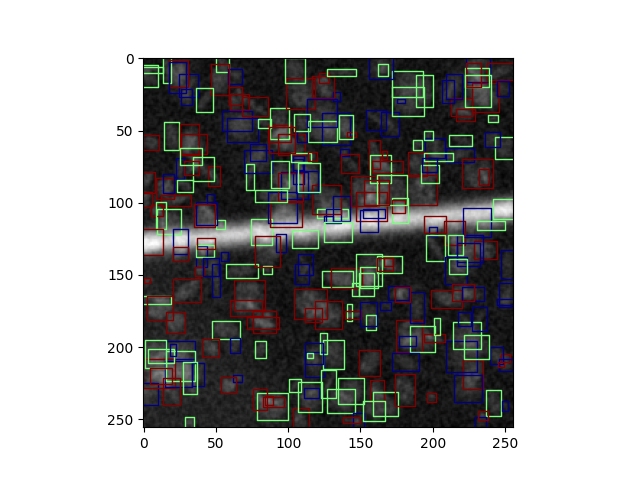

In [9]:
I,bbox,cl = groundtruth[0]
fig,ax = plt.subplots()
#ax.imshow(I[0],cmap='gray')
imshow(I,ax,cmap='gray')
polys = bbox_to_rectangles(bbox,fc='none')
polys.set_edgecolor(plt.cm.jet(cl*255//(nclasses-1)))
ax.add_collection(polys)

In [10]:
class VariableConv2d(torch.nn.Module):
    ''' Note the assumption here is that we have batch size one, so I can work with the batch dimension'''
    def __init__(self,M):
        super().__init__()
        self.M = M
        self.c0  = torch.nn.Conv2d(1,M,3,1,1)
        self.c1 = torch.nn.Conv2d(1,M,3,1,1)
        
        self.c2 = torch.nn.Conv2d(1,M,3,1,1)
        self.c3 = torch.nn.Conv2d(M,1,3,1,1)
        
        
    def forward(self,x):
        #print(x.shape)
        # move the batch dim, make the size N x 1
        x = x[0,:,None]
        #print(x.shape)
        # filter it twice
        x0 = self.c0(x)
        #print(x0.shape)
        x1 = self.c1(x)
        #print(x1.shape)
        
        #print(x1.shape)
        # they are both N x M and I want to sum over M and get N x M
        #print(x0.shape,x1.shape)
        mat = torch.sum(x0[:,None]*x1[None,:],2)
        #print(mat.shape)
        mat = torch.softmax(mat,1)
        #print(mat.shape)
        
        x2 = self.c2(x)
        #print(x2.shape)
        tmp = mat[:,:,None]*x2[:,None,:] 
        #print(tmp.shape)
        tmp = torch.sum( tmp, 1)
        #print(tmp.shape)
        tmp = self.c3(tmp)
        #print(tmp.shape)
        out = tmp.transpose(0,1)
        #print(out.shape)
        return out
        
        
    

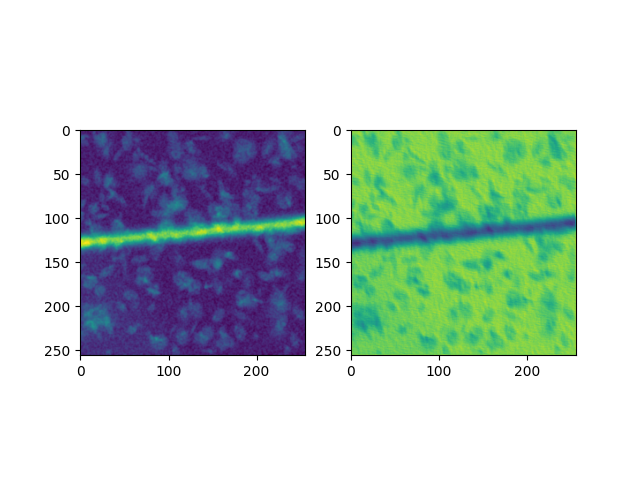

In [11]:
layer = VariableConv2d(8)
fig,ax = plt.subplots(1,2)
imshow(I,ax[0])
out = layer(torch.tensor(I,dtype=dtype)[None]).clone().detach()[0]
#print(I.shape,out.shape)
imshow(out,ax[1])

In [12]:
class VariableInputConv2d(torch.nn.Module):
    ''' Note the assumption here is that we have batch size one, so I can work with the batch dimension'''
    def __init__(self,M):
        super().__init__()
        self.M = M
        self.c  = torch.nn.Conv2d(1,M,3,1,1)
        
        
    def forward(self,x):
        #print(x.shape)
        # move the batch dim, make the size N x 1
        x = x[0,:,None]
        #print(x.shape)
        # apply the conv layer, make the size N x M
        cx = self.c(x)
        cx = torch.softmax(cx*100,0)
        
        # now matrix multiply
        out = torch.sum(x*cx,0,keepdims=True)
        self.out = out
        return out
        
        
    

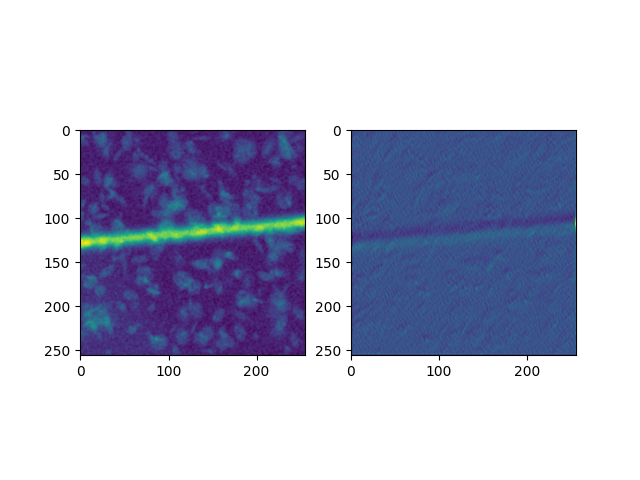

In [13]:
layer = VariableConv2d(8)
fig,ax = plt.subplots(1,2)
imshow(I,ax[0])
out = layer(torch.tensor(I,dtype=dtype)[None]).clone().detach()[0]
#print(I.shape,out.shape)
imshow(out,ax[1])

In [14]:

class VariableInputConv2d(torch.nn.Module):
    ''' Note the assumption here is that we have batch size one, so I can work with the batch dimension.
    This version adds a few extra convolutions.
    
    We only process 1 image at a time, so we can use the batch dimension.
    
    Step 1: move channel dimension to batch dimension.  Now we have N samples, with one channel each.
    
    Step 2: apply some convolutions and relus, to end up with an N x M array of images. Where M is fixed, 
            and N is variable.
    
    Step 3: Take a softmax of the result over the N channels.  Now matrix multiply, and N x M array, with a N x 1 array,
            to get an M x 1 array (where M is fixed).
    
    Step 4: Return the result which is a fixed number of channels.
    
    What's nice is it is permutation invariant.  So if we input an RGB image, or a BGR image, the result would be exactly the same.
    We don't need to have the channels in any specific order.
    
    
    '''
    def __init__(self,M):
        super().__init__()
        self.M = M
        self.c0  = torch.nn.Conv2d(1,M,3,1,1)
        self.c1  = torch.nn.Conv2d(M,M,3,1,1)
        self.c2  = torch.nn.Conv2d(M,M,3,1,1)
        
        
    def forward(self,x):
        #print(x.shape)
        # move the batch dim, make the size N x 1
        x = x[0,:,None]
        #print(x.shape)
        # apply the conv layer, make the size N x M
        cx = torch.relu(self.c0(x))
        cx = torch.relu(self.c1(cx))
        cx = self.c2(cx)
        cx = torch.softmax(cx*100,0)
        
        # now matrix multiply
        out = torch.sum(x*cx,0,keepdims=True)
        self.out = out
        return out
        
     
    

(3, 256, 256) torch.Size([1, 256, 256])


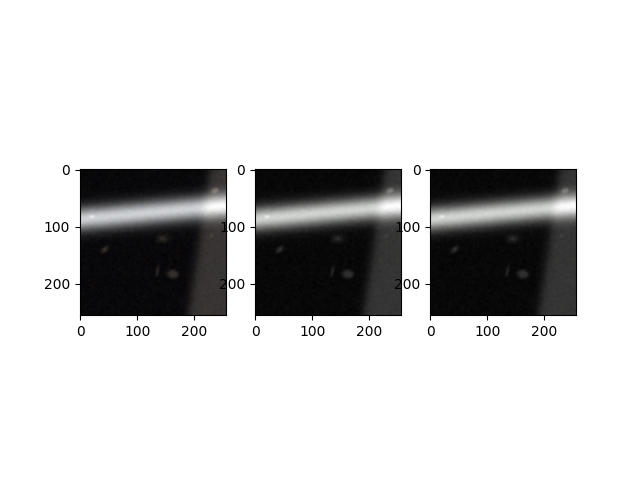

In [15]:
layer = VariableInputConv2d(3)
fig,ax = plt.subplots(1,3)
I,bbox,cls = groundtruth[0]
imshow(I,ax[0])

r = torch.randperm(I.shape[0])
out1 = layer(torch.tensor(I,dtype=dtype)[None]).clone().detach()[0]
out2 = layer(torch.tensor(I,dtype=dtype)[r][None]).clone().detach()[0] 
print(I.shape,out.shape)
imshow(out1,ax[1])
imshow(out2,ax[2])
# note the order of components doesn't matter

In [16]:
class BatchNorm2dRunningOnly(torch.nn.Module):
    '''
    Since we work with one image at a time, subtracting batch statistics is not always meaningful and
    can destroy information.
    
    Here we only work with running means and variances.    
    
    This didn't end up working.
    '''
    def __init__(self,num_features,eps=1e-05, momentum=0.1,**kwargs):
        # note I made the momentum parameter smaller so the running mean changes more slowly
        # it was 0.1 originally
        # any other keywords get ignored
        super().__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
    
        self.weight = torch.nn.parameter.Parameter( torch.ones(num_features))
        self.bias = torch.nn.parameter.Parameter(torch.zeros(num_features))
        
        self.register_buffer('running_mean',torch.zeros(num_features))
        self.register_buffer('running_mean2',torch.ones(num_features))
        
        
    def forward(self,x):
        # update the buffers (no gradients)
        with torch.no_grad():
            if not self.eval:
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*torch.mean(x,(0,-1,-2))
                self.running_mean2 = (1-self.momentum)*self.running_mean2 + self.momentum*torch.mean(x**2,(0,-1,-2))
        std = (self.running_mean2 - self.running_mean**2 + self.eps)**0.5
        x = (x - self.running_mean[...,None,None]) / std[...,None,None] 
        x = x * self.weight[...,None,None] + self.bias[...,None,None]
        return x
        

In [17]:
def iou(bbox0,bbox1,nopairwise=False):
    ''' Calculate pairwise iou.  
    The first argument is the row, second is col
    If nopairwise is True, we only compute it pointwise, not pairwise.
    '''
    if bbox0.ndim == 1: bbox0 = bbox0[None]
    if bbox1.ndim == 1: bbox1 = bbox1[None]
    if not nopairwise:
        bbox0 = bbox0[:,None]
        bbox1 = bbox1[None,:]
    # calculate the intersection over union for two bboxes
    # the intersection volume is pretty straightforward
    # we need to find the bigger left side, and the smaller right side (and vice versa)
    l0 = bbox0[...,0]
    l1 = bbox1[...,0]
    r0 = bbox0[...,0] + bbox0[...,2]
    r1 = bbox1[...,0] + bbox1[...,2]
    
    t0 = bbox0[...,1]
    t1 = bbox1[...,1]
    b0 = bbox0[...,1] + bbox0[...,3]
    b1 = bbox1[...,1] + bbox1[...,3]
    
    
    l = np.maximum(l0*np.ones_like(l1),l1*np.ones_like(l0))
    r = np.minimum(r0*np.ones_like(r1),r1*np.ones_like(r0))
    t = np.maximum(t0*np.ones_like(t1),t1*np.ones_like(t0))
    b = np.minimum(b0*np.ones_like(b1),b1*np.ones_like(b0))
    
    #print(l.shape)
    
    vol0 = (r0-l0)*(b0-t0)    
    vol1 = (r1-l1)*(b1-t1)    
    vol = (r-l)*(b-t) * (r>l) * (b>t) # could be 0
    
    # use de morgans law to get volume of union
    VOL = vol0 + vol1 - vol
    
    
    # calculate the iou
    return vol/VOL

In [18]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.chin = 16
        self.ch0 = 32
        # for now we are just doing the region proposal
        # 2*k scores and 4*k regressors
        
        self.padding_mode='reflect'
        
        self.B = 2 # bounding boxes per block
        #self.B = 1
        self.C = nclasses # number of classes, conditioned on their being an object
        self.chout = self.B*5 + self.C
        # 5 numbers per box, cx, cy, width, height, confidence
        # confidence is a predition of p(object)*IOU
        
        self.color = VariableInputConv2d(self.chin)
        
        self.bn = torch.nn.BatchNorm2d # i also set track running stats to false, so eval mode will be the same as train mode
        #self.bn = BatchNorm2dRunningOnly
        
        self.c0 = torch.nn.Conv2d(self.chin,self.ch0,3,1,1,padding_mode=self.padding_mode) # no downsampling
        self.b0 = self.bn(self.ch0,track_running_stats=False)
        self.c0a = torch.nn.Conv2d(self.ch0,self.ch0,3,1,1,padding_mode=self.padding_mode)
        self.b0a = self.bn(self.ch0,track_running_stats=False)
        
        self.c1 = torch.nn.Conv2d(self.ch0,self.ch0*2,3,2,1,padding_mode=self.padding_mode)
        self.b1 = self.bn(self.ch0*2,track_running_stats=False)
        self.c1a = torch.nn.Conv2d(self.ch0*2,self.ch0*2,3,1,1,padding_mode=self.padding_mode)
        self.b1a = self.bn(self.ch0*2,track_running_stats=False)
        
        self.c2 = torch.nn.Conv2d(self.ch0*2,self.ch0*4,3,2,1,padding_mode=self.padding_mode)
        self.b2 = self.bn(self.ch0*4,track_running_stats=False)
        self.c2a = torch.nn.Conv2d(self.ch0*4,self.ch0*4,3,1,1,padding_mode=self.padding_mode)
        self.b2a = self.bn(self.ch0*4,track_running_stats=False)
        
        
        
        self.c3 = torch.nn.Conv2d(self.ch0*4,self.ch0*8,3,2,1,padding_mode=self.padding_mode)
        self.b3 = self.bn(self.ch0*8,track_running_stats=False)
        self.c3a = torch.nn.Conv2d(self.ch0*8,self.ch0*8,3,1,1,padding_mode=self.padding_mode)
        self.b3a = self.bn(self.ch0*8,track_running_stats=False)
        
        
        self.c4 = torch.nn.Conv2d(self.ch0*8,self.chout,1,1,padding_mode=self.padding_mode)
        

        
        # the total stride is important for interpretting the bounding box in the rpn
        self.stride = 8
        
        
    def forward(self,x,rpn=True):
        
        # color         
        x = self.color(x)
        
        # here x is a batch of images
        x = self.c0(x)
        x = self.b0(x)
        x = torch.relu(x)
        
        x = self.c0a(x)
        x = self.b0a(x)
        x = torch.relu(x)
        
        
        
        x = self.c1(x)
        x = self.b1(x)
        x = torch.relu(x)
        
        x = self.c1a(x)
        x = self.b1a(x)
        x = torch.relu(x)
        

        
        
        x = self.c2(x)
        x = self.b2(x)
        x = torch.relu(x)

        x = self.c2a(x)
        x = self.b2a(x)
        x = torch.relu(x)

        
        x = self.c3(x)
        x = self.b3(x)
        x = torch.relu(x)
        
        x = self.c3a(x)
        x = self.b3a(x)
        x = torch.relu(x)
        
        x = self.c4(x)
        
        
        return x
        

In [19]:
net = Net()
out = net(torch.tensor(I[None],dtype=dtype))
out.shape

torch.Size([1, 13, 32, 32])

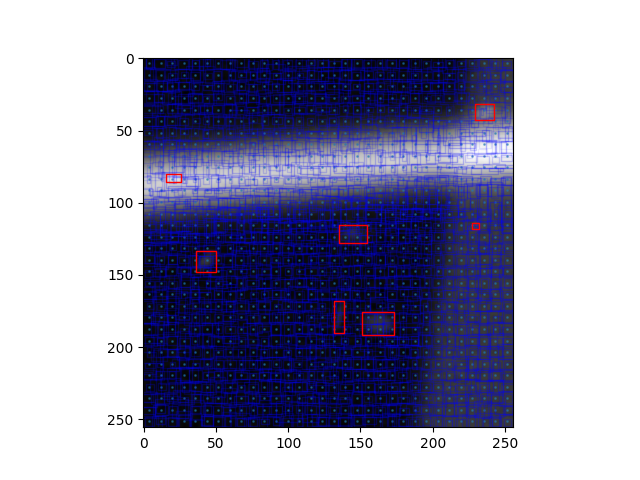

In [20]:
# we need to transform the outputs into bounding boxes
# for this we need a parameterization
# now YOLO assumes a fixed size, which I don't want to do
# my parameterization will therefore be
# xyshift (a number between -0.5 and 0.5, relative to grid size)
# hwscale (relative to grid size, )

# so we need a function to do this transformation
# number of bounding boxes
B = net.B
stride = net.stride
def convert_data(out,B,stride):
    ''' This function converts the output of the network into bounding boxes
    for evaluation.  Not differentiable.
    
    AND
    
    It also outputs the raw data, reformmated into a list intsead of an image of grid cells.
    These outputs are differentiable.  The last one of these outputs is the score (data[...,-1]).
    
    '''
    # get the positions of the grid cells
    x = torch.arange(out.shape[-1])*stride + (stride-1)/2
    y = torch.arange(out.shape[-2])*stride + (stride-1)/2
    YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)

    

    bboxes = []
    data = []
    for i in range(B):
        # get the five numbers
        outB = out[:,5*i:5*(i+1)]
        # get the standard bounding box coordinates
        # these are for drawing, computing overlap
        # the don't go into the loss
        x = (torch.sigmoid(outB[:,0])-0.5)*stride + YX[1] # between -0.5 and 0.5, scaled
        y = (torch.sigmoid(outB[:,1])-0.5)*stride + YX[0]
        w = torch.exp(outB[:,2])*stride
        h = torch.exp(outB[:,3])*stride
        x = x - w/2
        y = y - h/2

        bboxes.append(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).clone().detach())

        # now the data that I actually need for the loss
        # needs to be differentiable

        c = torch.sigmoid(outB[:,4])


        # these numbers need to be compared to the appropriate boxes
        cx = torch.sigmoid(outB[:,0])-0.5
        cy = torch.sigmoid(outB[:,1])-0.5
        ws = torch.exp(outB[:,2])
        hs = torch.exp(outB[:,3])    
        data.append(torch.stack((cx.ravel(),cy.ravel(),ws.ravel(),hs.ravel(),c.ravel(),)))


    bboxes = torch.cat(bboxes,-1).T
    data = torch.cat(data,-1).T

    
    
    return bboxes,data
B = net.B
stride = net.stride
bboxes,data = convert_data(out,B,stride)


fig,ax = plt.subplots()
x = torch.arange(out.shape[-1])*stride + (stride-1)/2
y = torch.arange(out.shape[-2])*stride + (stride-1)/2
YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)
ax.imshow(I[0],cmap='gray')
ax.scatter(YX[1].ravel(),YX[0].ravel(),s=1,alpha=0.5)
x = bboxes[...,0]
y = bboxes[...,1]
w = bboxes[...,2]
h = bboxes[...,3]
c = data[...,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='b',alpha=c.clone().detach()*0.5)
ax.add_collection(predicted_rectangles,)

true_rectangles = bbox_to_rectangles(bbox,fc='none',ec='r')
ax.add_collection(true_rectangles,)
fig.canvas.draw()

In [21]:
# transform the true bounding boxes
# to do this first we need an assignment to a given cell

def get_assignment_inds(bboxes,bbox,shape,stride):
    '''
    Assigns each training bounding box to a specific cell, and picks the bounding
    box from that cell with the best iou.
    '''
    # this should be the shape of the outputs
    x = np.arange(shape[-1])*stride + (stride-1)/2
    y = np.arange(shape[-2])*stride + (stride-1)/2
    YX = np.stack(np.meshgrid(y,x,indexing='ij'),0).reshape(2,-1)

    cx_bbox = bbox[...,0] + bbox[...,2]/2
    cy_bbox = bbox[...,1] + bbox[...,3]/2



    # each bbox should lie in exactly one cell
    d2 = (cx_bbox[:,None] - YX[1,None,:])**2 + (cy_bbox[:,None] - YX[0,None,:])**2
    assignment_inds = np.argmin(d2,-1)        
    # the assignment ind will be used for classification


    # after I figure out the cell I will calculate IOU
    # and pick the best
    # note the diag here is not a good idea, I need to avoid pairwise and just do it pointwise
    ious = []
    for i in range(B):
        #ious.append( np.diag(iou(bboxes[assignment_inds+(bboxes.shape[0]//B)*i].numpy(),bbox) ))    
        ious.append( iou(bboxes[assignment_inds+(bboxes.shape[0]//B)*i].numpy(),bbox,nopairwise=True) )
    ious = np.stack(ious,0)    
    B_inds = np.argmax(ious,0)    
    assignment_inds = assignment_inds + ((B_inds*bboxes.shape[0]//B)*i)
    # get the right ind for each iou    
    # I need to find a better way than the below, OK use take_along_axis
    #print(ious.shape,B_inds.shape)
    #return assignment_inds, np.array([i[b] for i,b in zip(ious.T,B_inds)])
    return assignment_inds, np.take_along_axis(ious,B_inds[None],axis=0)[0]
shape = out.shape
B = net.B

assignment_inds,ious = get_assignment_inds(bboxes,bbox,shape,stride)
bboxes_assigned = bboxes[assignment_inds]
x = bboxes_assigned[...,0]
y = bboxes_assigned[...,1]
w = bboxes_assigned[...,2]
h = bboxes_assigned[...,3]
c = data[assignment_inds,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='g',alpha=c.clone().detach())
ax.add_collection(predicted_rectangles,)

In [22]:
def get_best_bounding_box_per_cell(bboxes,scores,B):
    #scores = data[:,-1]
    scores_ = scores.reshape(B,-1)
    inds = torch.argmax(scores_,0)
    scores_ = torch.take_along_dim(scores_,inds[None,:],0).squeeze()


    bboxes_ = bboxes.reshape(B,-1,4)
    bboxes_ = torch.take_along_dim(bboxes_,inds[None,:,None],0).squeeze()

    return bboxes_,scores_

In [23]:
# now that we have assignment inds and ious
# we also need the target regression parameters
shape = out.shape
stride = net.stride
B = net.B


def get_reg_targets(assignment_inds,bbox,B,shape,stride):
    '''What are the true bounding box parameters we want to predict.'''
    # get the yx positions of each bbox
    x = np.arange(shape[-1])*stride + (stride-1)/2
    y = np.arange(shape[-2])*stride + (stride-1)/2
    YX = np.stack(np.meshgrid(y,x,indexing='ij'),0).reshape(2,-1)


    cx_assigned = YX[1].ravel()[assignment_inds%(shape[-1]*shape[-2])]
    cy_assigned = YX[0].ravel()[assignment_inds%(shape[-1]*shape[-2])]

    cx_true = bbox[:,0] + bbox[:,2]/2
    cy_true = bbox[:,1] + bbox[:,3]/2

    shiftx = (cx_true - cx_assigned)/stride
    shifty = (cy_true - cy_assigned)/stride

    scalex =(bbox[:,2]/stride)
    scaley = (bbox[:,3]/stride)
    
    return shiftx,shifty,scalex,scaley
shape = out.shape
stride = net.stride
B = net.B    
shiftx,shifty,scalex,scaley = get_reg_targets(assignment_inds,bbox,B,shape,stride)    
    

In [24]:
lr = 1e-4
optimizer = torch.optim.Adam(net.parameters(),lr=1e-4)
cls_loss = torch.nn.CrossEntropyLoss(reduction='sum')


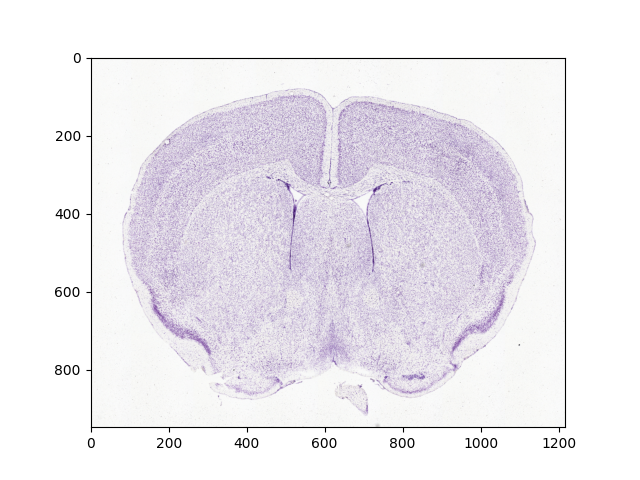

In [25]:
if user == 'abenneck':
    J = plt.imread('/home/abenneck/Desktop/YOLO/section_000197_30800.jpeg')
else:
    J = plt.imread('/home/dtward/data/AllenInstitute/ARA/section_000197_30800.jpeg')

J= J[...,:3]
if J.dtype == np.uint8:
    J = J / 255.0
J = J.transpose((-1,0,1))
#J = np.mean(J,-1)
fig,ax = plt.subplots()
imshow(J[:,::8,::8],ax)

In [ ]:
import time

Esave = []


nepochs = 2500
fig,ax = plt.subplots(2,3,figsize=(9,6)) 
ax = ax.ravel()
fig1,ax1 = plt.subplots(3,3,figsize=(9,9))
fig1.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.1,wspace=0.1)

if resume:        
    net.load_state_dict(torch.load(join(outdir,modelname)))
    optimizer.load_state_dict(torch.load(join(outdir,optimizername)))
    #Esave,Ersave,Ecsave = torch.load(join(outdir,lossname))
    Esave = torch.load(join(outdir,lossname))[0]
for e in range(nepochs):    
    if resume and e < len(Esave):
        continue
    count = 0
    Esave_ = []    
    for I,bbox,cl in groundtruth:
        optimizer.zero_grad()
        # run through the net
        out = net(torch.tensor(I[None],dtype=torch.float32))
        
        # convert the data into bbox format
        bboxes,data = convert_data(out,net.B,net.stride)
        
        # get assignments
        assignment_inds,ious = get_assignment_inds(bboxes,bbox,out.shape,net.stride)
        unassigned_inds = np.array([a for a in range(bboxes.shape[0]) if a not in assignment_inds])
        
        
        # get target parameters
        shiftx,shifty,scalex,scaley = get_reg_targets(assignment_inds,bbox,net.B,out.shape,net.stride)    

        
        # now build the loss function
        data_assigned = data[assignment_inds]
        targets = np.stack((shiftx,shifty,scalex,scaley,ious),-1)
        
        # this is the mean square error for assigned
        # they used a weight of 0.5 for noobj
        # note that in the paper they used a different loss for the scales (take the square root first)
        Ecoord = torch.sum((data_assigned[:,:4]-torch.tensor(targets[:,:4]))**2)*5
        # if it is assigned ot an object we want to predict the iou
        Eobj = torch.sum((data_assigned[:,-1]-torch.tensor(targets[:,-1]))**2)
        # if there is no object assigned we want to predict 0
        Enoobj = torch.sum((data[unassigned_inds,-1]-0)**2)*0.5
        # and we want to classify
        classprobs = out[:,-nclasses:].reshape(nclasses,-1)
        classprobs_assigned = classprobs[...,assignment_inds%(out.shape[-1]*out.shape[-2])]
        # note the paper uses mean square error on the probability vector
        # here I use cross entropy
        Ec = cls_loss(classprobs_assigned[None],torch.tensor(cl)[None])
        
        #print(Ecoord.item(),Eobj.item(),Enoobj.item(),Ec.item())
        
        E = Ecoord + Eobj + Enoobj + Ec
        
        Esave_.append(E.item())
        
        
        
        E.backward()
        
        optimizer.step()
        
        count += 1
        if count >= len(groundtruth): break
    
    
    

    
    # draw        
    Esave.append(np.mean(Esave_))
    #Ersave.append(np.mean(Ersave_))
    #Ecsave.append(np.mean(Ecsave_))
    ax[0].cla()
    ax[0].plot(Esave,label='loss')
    #ax[0].plot(Ersave,label='reg')
    #ax[0].plot(Ecsave,label='cls')
    ax[0].legend()
    ax[0].set_yscale('log')
    ax[0].set_title('training loss')
    
    
    ax[1].cla()
    #ax[1].imshow(I[0],cmap='gray',vmin=0,vmax=1)
    #imshow(I,ax[1],cmap='gray',vmin=0,vmax=1)
    imshow(net.color.out.clone().detach()[0],ax[1])
    ax[1].add_collection(bbox_to_rectangles(bbox,fc='none',ec=[0.5,0.5,0.5,0.5]))
    
    # get better colors
    p = torch.softmax(classprobs.clone().detach(),0)
    c0 = torch.tensor([1.0,0.0,0.0])
    c1 = torch.tensor([0.0,1.0,0.0])
    colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None])  ).T.numpy()    
    if nclasses == 3:
        c2 = torch.tensor([0.0,0.0,1.0])
        colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None]) + (p[2]*c2[...,None]) ).T.numpy()    
    #colors = colors.repeat(net.B,axis=0)
    
    
    #colors = 'r'
    bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,data[:,-1].clone().detach(),net.B)
    # TODO: we need to select only one bounding box per cell (the one with the higher predicted IOU)
    ax[1].add_collection(bbox_to_rectangles(bboxes_,fc='none',ec=colors,ls='-',alpha=scores_))
    #ax[1].add_collection(bbox_to_rectangles(bboxes[assignment_inds],fc='none',ec='g',alpha=0.5))
    ax[1].set_title('Annotations')
    
    
    classprob = torch.softmax(out.clone().detach()[0,-nclasses:],0)
    mask = torch.sigmoid(out[0,4].clone().detach())
    ax[2].cla()
    ax[2].imshow(mask,vmin=0,vmax=1,interpolation='gaussian')
    ax[2].set_title('Predicted score (pobj*iou)')
    #mask = mask*0+1
    ax[3].cla()    
    ax[3].imshow(   classprob[0]*mask  ,vmin=0,vmax=1,interpolation='gaussian')
    ax[3].set_title('Class 0 (smooth) prob map')
    
    ax[4].cla()
    ax[4].imshow(   classprob[1]*mask   ,vmin=0,vmax=1,interpolation='gaussian')
    ax[4].set_title('Class 1 (sharp) prob map')
    
    if nclasses == 3:
        ax[5].cla()
        ax[5].imshow(   classprob[2]*mask   ,vmin=0,vmax=1,interpolation='gaussian')
        ax[5].set_title('Class 2 (bumpy) prob map')
    fig.canvas.draw()
    
    
    
    with torch.no_grad():
        start = time.time()
        #I = plt.imread('/home/dtward/Pictures/Screenshots/Screenshot from 2025-01-14 13-52-23.png')[...,:3]
        #I = plt.imread('/home/dtward/Pictures/Screenshots/Screenshot from 2025-01-14 14-47-18.png')[...,:3]
        #I = np.mean(I,-1)[:256,:256][None]
        net.eval()
        for r in range(3):
            for c in range(3):
                ax1[r,c].cla()
                sl = (slice(r*2000+2000,r*2000+2000+256),slice(c*2000+2000,c*2000+2000+256))
                out = net(torch.tensor(J[(slice(None),)+sl][None],dtype=torch.float32))

                # convert the data into bbox format
                bboxes,data = convert_data(out,net.B,net.stride)

                #ax1[r,c].imshow(J[sl],cmap='gray')
                #imshow(J[sl])
                #imshow(net.color.out.clone().detach()[0],ax1[r,c])
                imshow(net.color.out.clone().detach()[0],ax1[r,c])

                classprobs = out[:,-nclasses:].reshape(nclasses,-1)
                p = torch.softmax(classprobs.clone().detach(),0)
                c0 = torch.tensor([1.0,0.0,0.0])
                c1 = torch.tensor([0.0,1.0,0.0])
                #colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None]) ).T.numpy()
                colors = 'r'
                bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,data[:,-1].clone().detach(),net.B)
                alpha = scores_.clone().detach()
                alpha = alpha * (alpha>0.5)
                
                ax1[r,c].add_collection(bbox_to_rectangles(bboxes_,fc='none',ec=colors,ls='-',alpha=alpha))
                ax1[r,c].axis('off')
        net.train()
        #print(f'{time.time() - start} seconds for example')
    fig1.canvas.draw()
    if not e%10:
        fig1.savefig(join(outdir,f'example_e_{e:06d}.png'))
    
    
    # save data
    torch.save(net.state_dict(),join(outdir,modelname))
    torch.save(optimizer.state_dict(),join(outdir,optimizername))
    #torch.save([Esave,Ersave,Ecsave],join(outdir,lossname))
    torch.save([Esave],join(outdir,lossname))
    

        
        

In [ ]:
# What to add
# I wasn't sure if the outputcan make more than one prediction per grid cell in evaluation mode.
# for now we're doing one prediction per grid cell in evaluation mode.
# 1. Set up a repo on twardlab (and add me to it)
# 2. Move all the functions and models into a .py file.  Keep the training in the notebook.  i.e.
#    any time this notebook has a "def" or a "class", that will be replaced by an import statement from 
#   the py file.
# 3. Make another notebook that loads the saved model and does prediction (this is how people will use it).
# 4. Add a tool for doing NMS, and a tool for calculating precision recall curves. Maybe you used an existing 
#    implementation in scikit learn.

## PR Curve Generation

In [ ]:
from sklearn.metrics import precision_recall_curve

# bbox = [cx, cy, w, h, conf]



data

In [78]:
groundtruth[0][2]

array([0, 2, 1, 1, 1, 0, 0, 0, 1, 1])

In [ ]:
fig

In [ ]:
fig

In [ ]:
fig1

In [27]:
import tifffile
K = tifffile.imread('/panfs/dong/RNAscope/SW230926-02A/TIFFS/SW230926-02A_1_16.tif')
K = K / np.max(K,axis=(-1,-2),keepdims=True)
K = K[...,::2,::2]
#K = K[0,None]
print(K.shape)

(5, 4879, 7296)


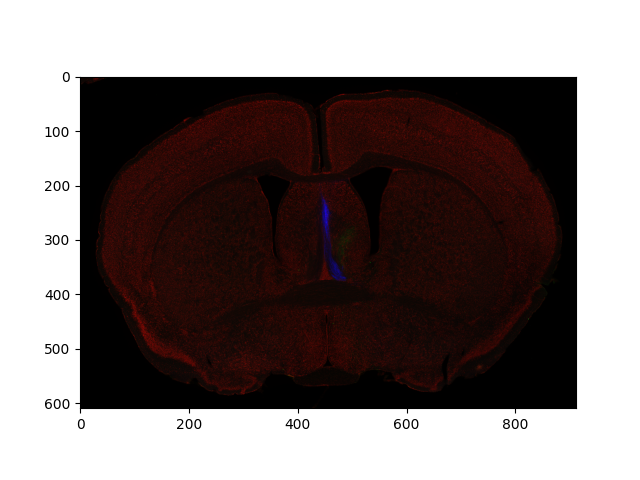

In [28]:
fig,ax= plt.subplots()
imshow(K[...,::8,::8],ax)

Net(
  (color): VariableInputConv2d(
    (c0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (c0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (b0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (c0a): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (b0a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (c1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
  (b1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (c1a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (b1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

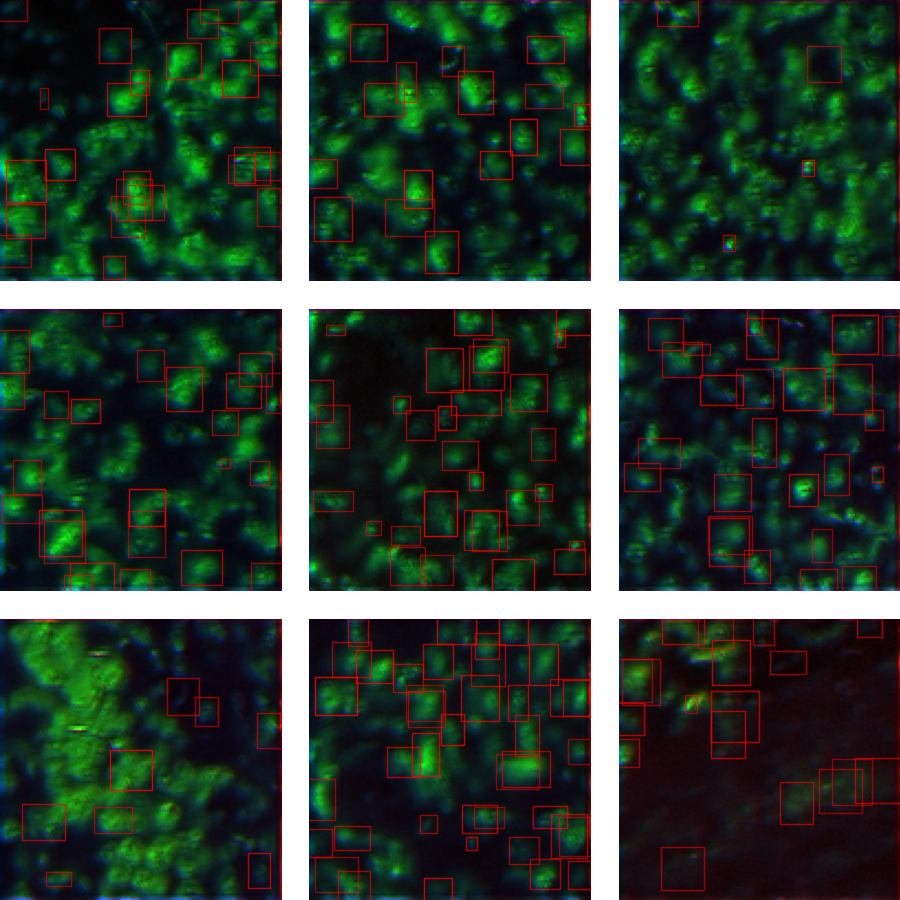

In [66]:
# another image to try
fig2,ax2 = plt.subplots(3,3,figsize=(9,9))
fig2.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.1,wspace=0.1)

net.eval()
n = 128
stride = 1024
for r in range(3):
    for c in range(3):
        ax1[r,c].cla()
        sl = (slice(r*stride+stride,r*stride+stride+n),slice(c*stride+stride,c*stride+stride+n))
        out = net(torch.tensor(K[(slice(None),)+sl][None],dtype=torch.float32))

        # convert the data into bbox format
        bboxes,data = convert_data(out,net.B,net.stride)

        #ax1[r,c].imshow(J[sl],cmap='gray')
        #imshow(K[sl],ax2[r,c])
        #imshow(net.color.out.clone().detach()[0],ax1[r,c])
        imshow(net.color.out.clone().detach()[0],ax2[r,c])

        classprobs = out[:,-nclasses:].reshape(nclasses,-1)
        p = torch.softmax(classprobs.clone().detach(),0)
        c0 = torch.tensor([1.0,0.0,0.0])
        c1 = torch.tensor([0.0,1.0,0.0])
        #colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None]) ).T.numpy()
        colors = 'r'
        bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,data[:,-1].clone().detach(),net.B)
        alpha = scores_.clone().detach()
        alpha = alpha * (alpha>0.5)

        ax2[r,c].add_collection(bbox_to_rectangles(bboxes_,fc='none',ec=colors,ls='-',alpha=alpha))
        ax2[r,c].axis('off')
net.train()



In [ ]:
# below here is scratch
asdf

In [ ]:
out = net(torch.tensor(J[(slice(None),)+sl][None],dtype=torch.float32))

In [ ]:
fig,ax = plt.subplots()
imshow(net.color.out.clone().detach()[0],ax)

In [ ]:
Esave

In [ ]:
fig,ax = plt.subplots()
ax.hist(mask.numpy().ravel())

In [ ]:
colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None]) ).T.numpy()

In [ ]:
colors.shape

In [ ]:
bboxes.shape,data[:,-1].shape

In [ ]:
I.shape

In [ ]:
data_assigned.shape,shiftx.shape

In [ ]:
data.shape,shiftx.shape

In [ ]:
I,bbox,cl = groundtruth[0]
fig,ax = plt.subplots()
imshow(I,ax)

In [ ]:
I.shape

In [ ]:
I,bbox,cls = groundtruth[0]
out = net(torch.tensor(I,dtype=dtype)[None])
bboxes,data = convert_data(out,net.B,net.stride)
fig,ax = plt.subplots(1,3)
imshow(I,ax[0])
imshow(net.color.out.clone().detach()[0][0:],ax[1])
imshow(net.color.out.clone().detach()[0][0:],ax[2])

'''
scores = data[:,-1]
scores_ = scores.reshape(-1,B)
inds = torch.argmax(scores_,-1)
scores_ = torch.take_along_dim(scores_,inds[:,None],1)[...,0]

bboxes_ = bboxes.reshape(-1,B,4)
bboxes_ = torch.take_along_dim(bboxes_,inds[:,None,None],1)[:,0]
'''

scores = data[:,-1].clone().detach()

bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,scores,B)



ax[2].add_collection(bbox_to_rectangles(bboxes_,fc='none',ec=colors,ls='-',alpha=scores_.clone().detach()))


In [ ]:
a = np.random.randn(2,10)
b = np.random.randint(0,2,10)

In [ ]:
a,b

In [ ]:
np.take_along_axis(a,b[None],axis=0).shape

In [ ]:
a.shape,b.shape

In [ ]:
bboxes_.shape

In [ ]:
out